## Sentiment Analysis

![감정분석 다이어그램](figs/sentiment_analysis.jpg)

> Reference : https://www.kdnuggets.com/2018/03/5-things-sentiment-analysis-classification.html

### 감정분석이란?

* text classification의 방법중에 한 가지로, Natural Language Processing, Text Analysis, Computational Lingustics, biometrics 같은 방법을 이용하여 텍스트에 숨겨져있는 저자의 의도나 정보를 찾아내는 모든 방법들을 말한다.


* Opinion Mining, Sentiment Mining, Subjectivity Analysis 라고도 불리기도 한다.


* sentiment analysis에는 다양한 방법들이 있지만, 가장 많이 쓰이는 방법인 text classification으로서의 sentiment analysis를 공부해보고, 추가적으로 생각해볼 여러 가지 이슈에 대해 고민해보자!

## Sentiment Analysis with Naver Movie Sentiment Corpus

* 감정분석을 위해, Naver Movie Corpus(https://github.com/e9t/nsmc/)를 사용합니다.

In [1]:
def read_documents(filename):
    with open(filename) as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
        return documents
    
train_docs = read_documents("data/ratings_train.txt")
test_docs = read_documents("data/ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


In [3]:
#불용어들을 추가합니다. 국립언어원 공식 한국어불용어 100개와 추가하고싶은 단어들을 추가합니다. 기본적으로 공백과, 특수문자들을 제거했습니다.
import string

SW = set()
SW.add(" ")
SW.add("○")
SW.add("있는")
SW.add("국립중앙박물관")

for i in string.punctuation:
    SW.add(i)

with open("data/한국어불용어100.txt", 'r', encoding="utf-8") as f:
    for line in f:
        stop_word = line.split()[0]
        SW.add(stop_word)

* 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [8]:
from konlpy.tag import Okt
import json
import os
from pprint import pprint

okt = Okt()

def text_tokenizing(doc):
    return [word for word in okt.nouns(doc) if word not in SW and len(word) > 1]

if os.path.exists('train_docs.json'):
    with open("train_docs.json") as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
#     train_data = []
#     for line in train_docs:
#         if text_tokenizing(line[1]):
#             train_data.append((text_tokenzing(line[1]), line[2]))
    
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json") as f:
        train_data = json.load(f)
else:
    test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

(['더빙', '진짜', '목소리'], '0')
(['평점', '더욱'], '0')


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

In [9]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

659954


In [10]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

37085
[('영화', 50737),
 ('정말', 9645),
 ('진짜', 8343),
 ('연기', 6434),
 ('평점', 6324),
 ('최고', 6035),
 ('스토리', 5344),
 ('드라마', 5063),
 ('감동', 4879),
 ('보고', 4612)]


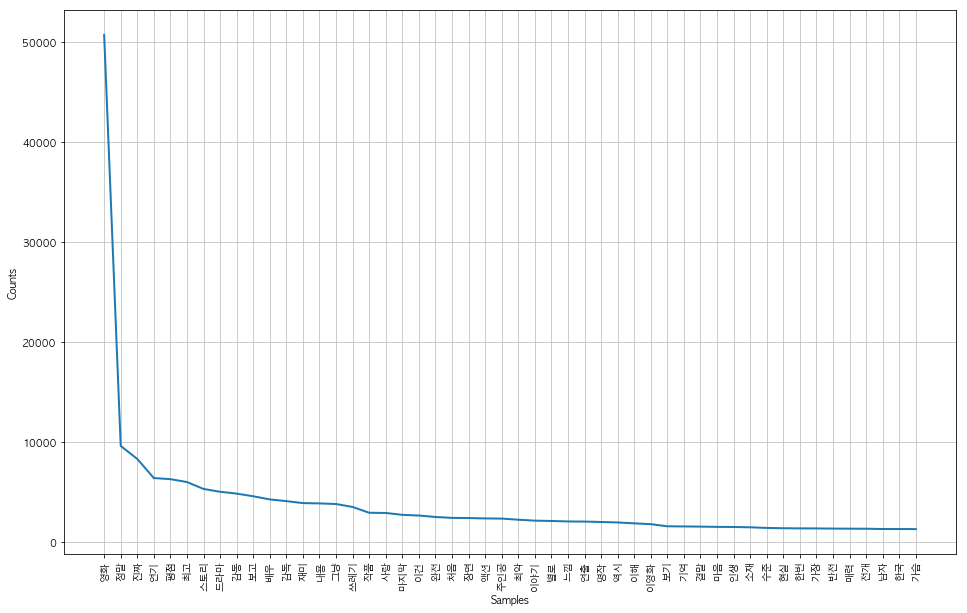

In [11]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

In [15]:
# 여러 리스트들을 하나로 묶어 주는 함수입니다.
def list_to_str(List): 
    return " ".join(List)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import numpy as np

train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

#print(len(train_x), len(train_y))
print("For %d train data" % len(train_x))
#print(len(test_x), len(test_y))

learner = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100))
])

learner2 = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf', SVC(kernel='linear'))
    
])

learner3 = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf', SVC(kernel='poly', degree=8))
])

learner4 = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf', SVC(kernel='rbf'))
])

learner5 = Pipeline([
    ('vect', CountVectorizer(max_features=500)),
    ('clf', SVC(kernel='sigmoid'))
])

learner4.fit(train_x, train_y)
train_predict = learner4.predict(train_x)
train_accuracy = np.mean(train_predict == train_y)

test_predict = learner4.predict(test_x)
test_accuracy = np.mean(predict == test_y)


print("For %d test data" % len(test_x))

print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 138826 train data
For 46419 test data
Training Accuracy : 0.51
Test Accuracy : 0.50
